# Generate Audio for Behavior Task

## Initial setup

In [1]:
import wave, struct, math
import numpy as np
from scipy import signal
import os, json
import matplotlib.pyplot as plt

In [2]:
output_dir = os.getcwd()
print(output_dir)

/home/ckemere/Code/TreadmillIO/ClientSide/Sounds


## Tone Cloud

### Generate audio file

## Tone cloud
It's difficult to find references, especially with actual code (or anything more than a simple figure). I'll probably go through the labview code in order to see how the McGinley lab does it.

### Naive (no border correction)
Without gating at bin edges, large artifacts appear at discontinuities between chords.

In [3]:
def sample_octaves(f_low, f_high, size=1):
    return np.exp(np.log(f_low) + (np.log(f_high) - np.log(f_low))*np.random.random(size=size))

In [4]:
# Settings
fs = 96000.0 # Hz
T = 1.0 # duration (s)
A_max = 2**15-1 # max amplitude (short)
A = 0.25*A_max # sample amplitude
num_tones = 5 # number of tones in chord
f_low = 2000 # low frequency (Hz)
f_high = 40000 # high frequency (Hz)
t_chord = 0.050 # chord duration (s)

# Determine sample numbers
N = int(fs*T)
num_chords = int(T/t_chord)
n_chord = int(t_chord*fs)

# Generate chords
y = np.zeros(N)
t = np.arange(n_chord) / fs
for i in range(num_chords):
    f_c = sample_octaves(f_low, f_high, size=num_tones) # get frequencies of tones
    y_c = np.sin(2*math.pi*f_c[:, np.newaxis]*t[np.newaxis, :]) # create chord
    y[i*n_chord:(i+1)*n_chord] = np.sum(y_c, axis=0) # add to sequence

# Normalize and convert data type
y = (y*(A/np.max(y))).astype(np.int16) # normalize

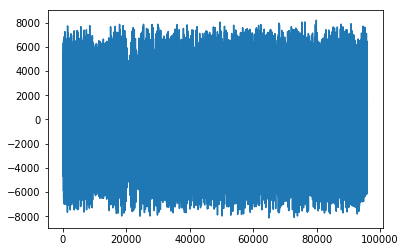

In [5]:
plt.plot(y)

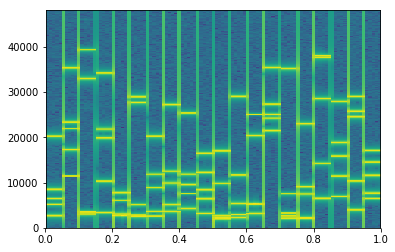

In [6]:
plt.specgram(y, Fs=int(fs), NFFT=1024);

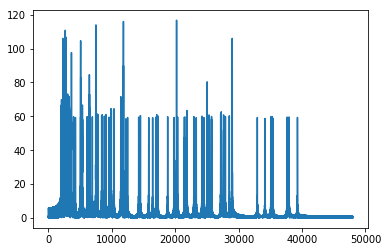

In [7]:
freq, Pxx = signal.periodogram(y, fs=fs)
plt.plot(freq[1:-1], np.sqrt(Pxx[1:-1]));

### Border correction


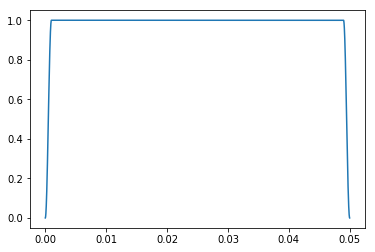

In [8]:
# Create gate
t_gate = 0.005 # seconds
f_gate = 1.0/(2*t_gate) # t_gate = 0.5*period
gate = np.ones(len(t))
idx = int(t_gate*fs) # last/first index of ramping
gate[:idx] = (1.0 + np.cos(2*math.pi*f_gate*t[:idx] + math.pi))/2
gate[-idx:] = gate[:idx][::-1]

plt.plot(t, gate);

In [9]:
# Settings
fs = 96000.0 # Hz
T = 1.0 # duration (s)
A_max = 2**15-1 # max amplitude (short)
A = 0.5*A_max # sample amplitude
num_tones = 5 # number of tones in chord
f_low = 2000 # low frequency (Hz)
f_high = 40000 # high frequency (Hz)
t_chord = 0.050 # chord duration (Hz)

# Determine sample numbers
N = int(fs*T)
num_chords = int(T/t_chord)
n_chord = int(t_chord*fs)

# Generate chords
y = np.zeros(N)
t = np.arange(n_chord) / fs
for i in range(num_chords):
    f_c = sample_octaves(f_low, f_high, size=num_tones) # get frequencies of tones
    y_c = np.sin(2*math.pi*f_c[:, np.newaxis]*t[np.newaxis, :]) # create chord
    y[i*n_chord:(i+1)*n_chord] = gate*np.sum(y_c, axis=0) # add to sequence

# Normalize and convert data type
y = (y*(A/np.max(y))).astype(np.int16) # normalize

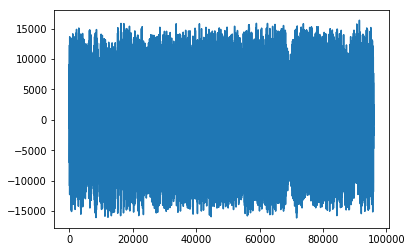

In [22]:
plt.plot(y);

In [ ]:
plt.specgram(y.real, Fs=int(fs), NFFT=512);

In [18]:
t = np.arange(0,2*np.pi,0.001)
x = np.sin(t)
print(np.sqrt(np.mean(x**2)))
print(np.sqrt(np.mean((0.5*(x**2)))))

0.7070609430648978
0.4999675875533446


In [20]:
print('Normalized RMS of tone cloud: {}. RMS of a sine wave {}'.format(np.sqrt(np.mean((y.astype(float)/A)**2)), 1/np.sqrt(2)))

Normalized RMS of tone cloud: 0.3143841004453731. RMS of a sine wave 0.7071067811865475


### Generate audio

In [23]:
def tone_cloud(fs, T, A, 
               num_tones=5,
               f_low=2000,
               f_high=40000,
               t_chord=0.050,
               t_gate=0.005):
    # Determine number of samples
    N = int(fs*T)
    num_chords = int(T/t_chord)
    n_chord = int(t_chord*fs)
    t = np.arange(n_chord)/fs
    
    # Create sine gate at borders
    gate = np.ones(len(t))
    if t_gate > 0.0:
        f_gate = 1.0/(2*t_gate) # t_gate = 0.5*period
        idx = int(t_gate*fs) # last/first index of ramping
        gate[:idx] = (1.0 + np.cos(2*math.pi*f_gate*t[:idx] + math.pi))/2
        gate[-idx:] = gate[:idx][::-1]

    # Create chords (can run continuously if needed)
    y = np.zeros(N)
    for i in range(num_chords):
        f_c = sample_octaves(f_low, f_high, size=num_tones)
        y_c = np.sin(2*math.pi*f_c[:, np.newaxis]*t[np.newaxis, :])
        y[i*n_chord:(i+1)*n_chord] = gate*np.sum(y_c, axis=0)

    # Normalize
    return y*(A/np.max(y))

In [26]:
sampling_rates = [48000.0, 96000.0, 192000.0]

for fs in sampling_rates:
    sound_dir = os.path.join(output_dir, "{}kHz".format(int(fs/1000)))
    if not os.path.isdir(sound_dir):
        print('Creating output directory {}'.format(sound_dir))
        
        os.makedirs(sound_dir)

    filename = 'tone_cloud_short.wav'

    # Audio settings
    num_channels = 1 # 1 = mono, 2 = stereo (stereo doesn't work)
    T = 5.0 # duration (s)
    A_max = 2**15-1 # max amplitude (short)
    A = 0.5*A_max # sample amplitude
    num_tones = 5 # number of tones in chord
    f_low = 2000 # low frequency (Hz)
    f_high = 40000 # high frequency (Hz)
    t_chord = 0.050 # chord duration (s)
    t_gate = 0.005 # gate duration (s)

    with wave.open(os.path.join(sound_dir, filename),'wb') as wf:
        # File settings
        wf.setnchannels(num_channels)
        wf.setsampwidth(2) # 2 bytes = short
        wf.setframerate(fs)

        # Create sound
        y = tone_cloud(fs=fs, 
                       T=T, 
                       A=A,
                       num_tones=num_tones,
                       f_low=f_low,
                       f_high=f_high,
                       t_chord=t_chord,
                       t_gate=t_gate)
        y = y.astype(np.int16)

        # Write frames to file object
        for i in range(len(y)):
            s = struct.pack('<h', y[i]) # pack as short
            for j in range(num_channels):
                wf.writeframesraw(s)
                
        # Save sound parameters
    with open(os.path.join(sound_dir,filename.split('.')[0] + '.json'), 'w') as f:
        d = {'num_channels': num_channels,
             'fs': fs, 
             'T': T,
             'A': A,
             'num_tones': num_tones,
             'f_low': f_low,
             'f_high': f_high,
             't_chord': t_chord,
             't_gate': t_gate}
        f.write(json.dumps(d, indent=4))

In [ ]:
# Check file header
with wave.open(output_dir + filename, 'rb') as wf:
    T_actual = wf.getnframes() / wf.getframerate()
    print('Number of channels: %d' % wf.getnchannels())
    print('Duration:           %.2f' % T_actual)
    print('')

In [ ]:
# Play audio
print('Playing file %s (%.2f seconds)' % (filename, T_actual))
os.system('aplay %s' % (output_dir + filename))
print('done.')

In [ ]:
filename = 'tone_3kHz_square.wav'

# Audio settings
num_channels = 1
fs = 48000.0 # Hz
T = 5.0 # duration (s)
freq = 3000.0 # frequency (Hz)
A_max = 32767.0 # max amplitude (short)
A = 0.25*A_max

with wave.open(output_dir + filename,'wb') as wf:
    # File settings
    wf.setnchannels(num_channels) # mono
    wf.setsampwidth(2) # 2 bytes = short
    wf.setframerate(fs)

    # Write frames to file object
    for i in range(int(T * fs)):
        s = int(A* ((math.floor(math.sin(2*math.pi*freq*float(i)/fs)) + 0.5)*2))
        s = struct.pack('<h', s)
        for j in range(num_channels):
            wf.writeframesraw(s)

In [ ]:
# Save sound parameters
with open(output_dir + filename.split('.')[0] + '.json', 'w') as f:
    d = {'num_channels': num_channels,
         'fs': fs, 
         'T': T,
         'A': A,
         'frequency': freq}
    f.write(json.dumps(d, indent=4))

In [ ]:
# Check file header
with wave.open(output_dir + filename, 'rb') as wf:
    T_actual = wf.getnframes() / wf.getframerate()
    print('Number of channels: %d' % wf.getnchannels())
    print('Duration:           %.2f' % T_actual)
    print('')